In [96]:
import pandas as pd
import numpy as np
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, RobertaForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [ ]:
#hyper params

batch_size = 256
epochs = 4
lr = 5e-5
eps = 1e-8

In [2]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 3090


In [3]:
#read data
df = pd.read_csv("./data/train_data.csv")
print('Number of sentences: {:,}'.format(df.shape[0]))

Number of sentences: 45,654


# 테스트 데이터 나누기

In [4]:
train = df.sample(frac=0.9)
test = df.drop(train.index)
print("Number of train sentences: {:,}".format(len(train)))
print("Number of test sentences: {:,}".format(len(test)))

Number of train sentences: 41,089
Number of test sentences: 4,565


In [5]:
sentences = train.title.values
labels = train.topic_idx.values

test_sentences = test.title.values
test_labels = test.topic_idx.values

# Bert Tokinzer

In [6]:
tokenizer = BertTokenizer.from_pretrained('klue/roberta-base')

In [7]:
# 토큰을 붙였을 때 가장 긴 문장을 구함
max_len = 0

for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True) # 스패셜토큰 추가하여 encoding
    max_len = max(max_len, len(input_ids)) # mat_len 설정

print('Max sentence length: ', max_len)

Max sentence length:  29


In [8]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  경남도교육청 2020년 지방공무원 273명 채용…6월 13일 시험
Token IDs: tensor([    0,  4528,  2119,  6177,  2270,  7330,  2440,  3870,  2086,  4473,
        29970,  2211,  5142,   121,    26,  2429,  3876,  2210,  4448,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1])


In [10]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

36,980 training samples
4,109 validation samples


In [11]:
# 데이터로드 생성

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = RandomSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [12]:
model = RobertaForSequenceClassification.from_pretrained(
    "klue/roberta-base",
    num_labels = 7,
    output_attentions = False, 
    output_hidden_states = False,
    return_dict=False)

model.cuda()

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = lr, 
                  eps = eps )

In [14]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


training_stats = []
total_t0 = time.time()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time() # Measure how long the training epoch takes.
    total_train_loss = 0  # Reset the total loss for this epoch.

    model.train()

    for step, batch in enumerate(train_dataloader):

      
        if step % 100 == 0 and not step == 0:   # Progress update every 40 batches.
            elapsed = format_time(time.time() - t0)  # Calculate elapsed time in minutes.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,156.    Elapsed: 0:00:06.
  Batch   200  of  1,156.    Elapsed: 0:00:11.
  Batch   300  of  1,156.    Elapsed: 0:00:16.
  Batch   400  of  1,156.    Elapsed: 0:00:21.
  Batch   500  of  1,156.    Elapsed: 0:00:26.
  Batch   600  of  1,156.    Elapsed: 0:00:32.
  Batch   700  of  1,156.    Elapsed: 0:00:37.
  Batch   800  of  1,156.    Elapsed: 0:00:42.
  Batch   900  of  1,156.    Elapsed: 0:00:47.
  Batch 1,000  of  1,156.    Elapsed: 0:00:52.
  Batch 1,100  of  1,156.    Elapsed: 0:00:57.

  Average training loss: 0.48
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.40
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,156.    Elapsed: 0:00:05.
  Batch   200  of  1,156.    Elapsed: 0:00:10.
  Batch   300  of  1,156.    Elapsed: 0:00:15.
  Batch   400  of  1,156.    Elapsed: 0:00:20.
  Batch   500  of  1,156.    Elapsed: 0:00:26.
  Batch  

# visualization for training metrics

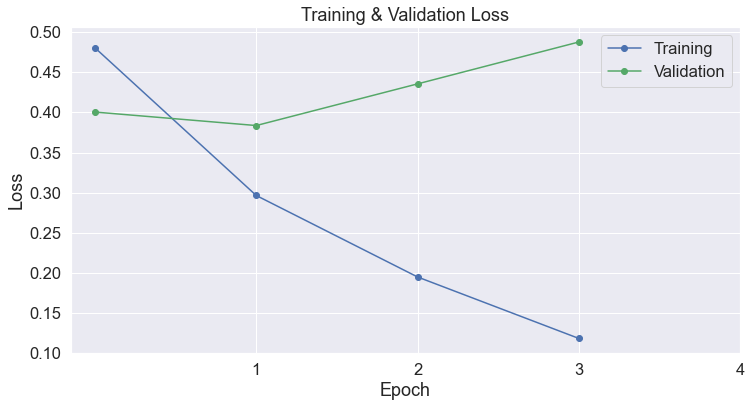

In [100]:
df_stats = pd.DataFrame(data=training_stats)
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [18]:
input_ids = []
attention_masks = []

for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(input_ids, dim=0)
test_attention_masks = torch.cat(attention_masks, dim=0)

In [19]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)

In [20]:
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    
    predictions +=  list(np.argmax(outputs[0].detach().cpu().numpy(), 1))

test['inference'] = predictions
print("Accuracy: {:.2f}" .format(len(test[test['topic_idx'] == test["inference"]])/len(test)))

DONE.


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

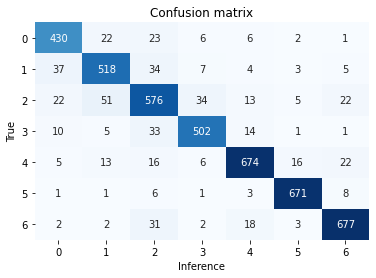

In [40]:
from sklearn import metrics

cm = metrics.confusion_matrix(test['topic_idx'], test['inference'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax= ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Inference', ylabel='True', title="Confusion matrix")
plt.yticks(rotation=0)

In [103]:
target= 1
infer= 2

temp = test[test['topic_idx']==target]
temp[temp['inference']==infer]

,index,title,topic_idx,inference
1010,1010,2차례 정전으로 일찍 문 닫은 창조경제 박람회종합,1,2
1606,1606,삼성 새만금 투자약속 철회 진실 밝혀라 목소리 봇물,1,2
7292,7292,정의 소상공인 생존권 위협하는 것은 최저임금 아닌 임대료,1,2
8389,8389,작년 전남 여수·고흥 여객선 승객 19%↑…야간운항 허용 때문,1,2
8475,8475,롯데 창립행사 경품으로 제네시스 G70 50대 푼다,1,2
10163,10163,네이버 뉴스 내 광고 수익 70% 언론사 배분키로,1,2
10249,10249,꽉막힌 경제 활로 찾는다 내달 고양서 한인경제인 대표자대회,1,2
12823,12823,윤호중 경제 양대수장 외국서 다른 시각 원정썰전 개탄,1,2
14701,14701,한낮 카풀 놓고 서울시스타트업계 충돌…위법성 논란종합,1,2
15708,15708,수은 등 10개 공공기관 카드사 지원받아 직원 해외여행,1,2


In [80]:

incorrect = test[test['topic_idx'] != test["inference"]].reset_index(drop=True)
incorrect[incorrect['inference'] == 6].head(20)

,index,title,topic_idx,inference
0,15,WMO 엘니뇨 여전히 강력…2분기엔 소멸될 듯,4,1
1,37,미군 정찰기 또 한반도 비행…북 방사포 발사 이후 감시 강화,4,6
2,155,베트남 언론 아시안게임 첫 4강 박항서 매직 뉴스로 도배,4,5
3,474,사드 불똥 20년 이어온 중국 연변 지용제 중단 위기,4,2
4,789,삼성 휴대폰 평균 판매가격 국내 514달러 해외선 197달러,0,1


,index,title,topic_idx,inference
1,37,미군 정찰기 또 한반도 비행…북 방사포 발사 이후 감시 강화,4,6
23,1832,특징주 남북경협주 북한 미사일 발사에 동반 하락,1,6
26,2015,국방부 드론 조종사에도 무공훈장 수여한다,4,6
30,2367,대북소식통 베이징 주재 북한 대표부 간부 탈북,4,6
33,2735,얘기 나누는 임종석 비서실장과 이효성 방통위원장,2,6
41,3320,국감현장 소형 EMP 충격기로 휴대폰 먹통 시연 눈길,2,6
49,3679,민주대사직 직업외교관 70% 법안 추진…보은인사 제동,4,6
70,4983,새 정부 4차산업 정책 미래부가 총괄…예산권도 부여종합,0,6
72,5058,여당 대구·경북 공천면접심사…현역 vs 진박 격돌,2,6
80,5429,청와대 감찰유출은 국기 흔드는 일…우 수사의뢰 정면돌파,2,6


In [87]:
correct = test[test['topic_idx'] == test["inference"]].reset_index(drop=True)
correct[correct['topic_idx'] == 0].head(20)

,index,title,topic_idx,inference
64,694,삼성전자 5G 기술로 MWC 공식방송 단독 생중계,0,0
71,746,네이버 뉴스 100% AI 편집은 부당…사람이 할 부분 있어종합,0,0
77,806,LG G6 실물사진 유출…둥근 모서리 화면·얇은 베젤 특징,0,0
106,1200,게시판 SK텔레콤 고3 학생에 ICT 체험 기회 제공,0,0
121,1324,갤노트9 첫날 개통량 갤S9보다 10%↑…보조금 꿈틀,0,0
124,1368,SK텔링크 데이터 차단 공부의 신 갤럭시와이드2 출시,0,0
126,1378,근육조직 생성에 필수적인 열쇠 발견,0,0
138,1512,만듦새는 네이버 쓰임새는 카카오…AI스피커 대결 장군멍군,0,0
144,1588,네이버 이미지 검색 고도화…DB 2배 이상 확대,0,0
159,1730,개통 첫날 암초 만난 갤럭시S8 …예판 열기 이어질까,0,0


# submission

In [48]:
test_df = pd.read_csv("./data/test_data.csv")
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

test_sentences = test_df.title.values

Number of test sentences: 9,131



In [50]:
max_len = 0

for sent in test_sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True) # 스패셜토큰 추가하여 encoding
    max_len = max(max_len, len(input_ids)) # mat_len 설정

print('Max sentence length: ', max_len)

Max sentence length:  30


In [51]:
input_ids = []
attention_masks = []

for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(input_ids, dim=0)
test_attention_masks = torch.cat(attention_masks, dim=0)

In [52]:
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)

In [53]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    
    predictions +=  list(np.argmax(outputs[0].detach().cpu().numpy(), 1))


print('DONE.')

Predicting labels for 9,131 test sentences...
DONE.


In [55]:
sub = pd.read_csv('./data/sample_submission.csv', index_col='index')
sub['topic_idx'] = predictions


In [56]:
sub.to_csv('./result/baseline_klue.csv')